In [92]:
import csv
import networkx as nx 
import numpy as np
import pandas as pd 
import community 
from itertools import compress
import matplotlib.pyplot as plt 
import seaborn as sns
from seaborn import color_palette, set_style, palplot
plt.style.use('ggplot')
%matplotlib inline

In [2]:
## read pre-processed data from stata
df = pd.read_stata('data/0_CPIS_CDIS_BIS_USTIC_merged_fixed1.dta')
df.columns.values

array(['country', 'countrycode', 'counterpart', 'counterpart_code', 'year',
       'CDIS_IADE', 'CDIS_IADD', 'CDIS_IAD', 'CDIS_IADF', 'CPIS_IAP',
       'CPIS_IAPE', 'CPIS_IAPD', 'loans_dep', 'total_claims'], dtype=object)

In [3]:
keep_var = ['countrycode','counterpart_code','country','counterpart','CDIS_IAD','CPIS_IAP','loans_dep']
df_2015 = df[df['year']==2015][keep_var]
df_2015.fillna(0,inplace=True)
df_2015.loc[df['CDIS_IAD']<0,'CDIS_IAD'] = 0                       # recode all negative values to 0 
df_2015.loc[df['CPIS_IAP']<0,'CPIS_IAP'] = 0                       # recode negative values to 0 

In [4]:
df_2015['total']=df_2015.CDIS_IAD + df_2015.CPIS_IAP+df_2015.loans_dep
df_2015 = df_2015[df_2015.total>0]

In [5]:
df_2015.describe()

,countrycode,counterpart_code,CDIS_IAD,CPIS_IAP,loans_dep,total
count,14724.000000,14724.000000,1.472400e+04,1.472400e+04,14724.000000,1.472400e+04
mean,460.082458,463.137726,2.599219e+03,2.853793e+03,1241.536894,6.694576e+03
std,287.263519,294.702209,2.623202e+04,3.163566e+04,15867.264313,6.314627e+04
min,111.000000,111.000000,0.000000e+00,0.000000e+00,-56.000000,3.000000e-08
25%,178.000000,178.000000,0.000000e+00,0.000000e+00,0.000000,1.195950e+00
50%,436.000000,433.000000,4.033089e-01,0.000000e+00,0.273500,1.999668e+01
75%,676.000000,686.000000,5.302071e+01,2.168891e+01,27.771249,3.086132e+02
max,968.000000,968.000000,1.115748e+06,1.369423e+06,940793.000000,2.577400e+06


In [6]:
## see how mancy countries we have
print(df_2015['country'].unique().shape)
print(df_2015['counterpart'].unique().shape)

(232,)
(234,)


#### so we have tow counterpart countries that don't have a origin, they are absorbing nodes, we need to take care of them. They are ['Curacao', 'Sint Maarten']

## Load network

In [7]:
## read from pandas datafrme 
G = nx.from_pandas_dataframe(df_2015, source="country", target="counterpart", edge_attr=['total'],create_using=nx.DiGraph()) ##,'CPIS_IAP','loans_dep'

In [8]:
# print out one particular edge, just to make sure it wroks 
G['United States']['United Kingdom']

{'total': 2577400.0}

In [9]:
# make sure the graph is created correctly 
df_2015[(df_2015.country == 'United States') & (df_2015.counterpart == 'United Kingdom')]

,countrycode,counterpart_code,country,counterpart,CDIS_IAD,CPIS_IAP,loans_dep,total
2420,111.0,112.0,United States,United Kingdom,717895.0,1244554.0,614951.0,2577400.0


In [10]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 234
Number of edges: 14724
Average in degree:  62.9231
Average out degree:  62.9231


In [11]:
## density 
nx.density(G)

0.2700561241333774

## Diameter and radius

## Explore Degrees 

/home/ubuntu/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


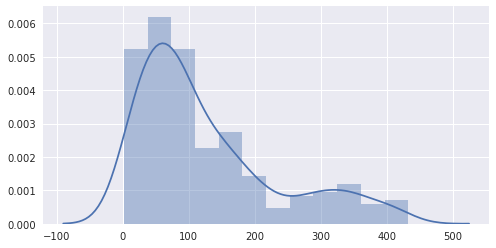

In [12]:
# Degree distribution
k = G.degree()
k =np.array(list(k.values()))
sns.set(rc={"figure.figsize": (8, 4)})
ax = sns.distplot(k)

In [13]:
# Find nodes with highest degree, unweighted 
k=G.degree()                                 ## get the degree centrality for all countries 
k = pd.DataFrame(list(k.items()),columns=['country','degree'])      ## make it into dataframe
k.sort_values(by='degree',ascending=0,inplace=True)                 ## sort it 
print('unweighted:')
k.head(5)

unweighted:


,country,degree
229,Italy,432
218,Switzerland,413
35,India,409
73,United Kingdom,406
33,Belgium,405


## Centrality measures

In [14]:
### Weighted degree centrality 
### This is the sum of both in and out folows 
d=nx.degree_centrality(G)                                 ## get the degree centrality for all countries 
degree = pd.DataFrame(list(d.items()),columns=['country','degree'])      ## make it into dataframe
degree.sort_values(by='degree',ascending=0,inplace=True)                 ## sort it 
degree.head(10)
## because it is a directd graph, centrality will be between 0,2

,country,degree
229,Italy,1.854077
218,Switzerland,1.772532
35,India,1.755365
73,United Kingdom,1.742489
33,Belgium,1.738197
224,France,1.708155
76,Luxembourg,1.690987
56,Canada,1.660944
28,Germany,1.583691
186,Austria,1.557940


In [15]:
## closeness
## nx.shortest_path_length(G)['United States']
c=nx.closeness_centrality(G)#distance ='rev_CDIS_IAD'                                  ## use CDIS_IAD data as distance mearuse, so the order should be reversed
closeness = pd.DataFrame(list(c.items()),columns=['country','closeness'])      ## make it into dataframe
closeness.sort_values(by='closeness',ascending=0,inplace=True)    
closeness.head(10)

,country,closeness
229,Italy,0.951020
218,Switzerland,0.892720
182,"Korea, Republic of",0.879245
73,United Kingdom,0.879245
33,Belgium,0.869403
28,Germany,0.866171
224,France,0.866171
35,India,0.859779
76,Luxembourg,0.859779
56,Canada,0.832143


In [16]:
## betweeness 
b = nx.betweenness_centrality(G)  # weight='total'
between = pd.DataFrame(list(b.items()),columns=['country','between'])      ## make it into dataframe
between.sort_values(by='between',ascending=0,inplace=True)    
between.head(10)

,country,between
229,Italy,0.062544
218,Switzerland,0.035051
35,India,0.033846
73,United Kingdom,0.033333
33,Belgium,0.030128
76,Luxembourg,0.028262
224,France,0.027056
28,Germany,0.025256
56,Canada,0.024785
199,United States,0.024031


In [17]:
## eigenvector centrality 
e = nx.eigenvector_centrality_numpy(G,weight='total')
eigenvector = pd.DataFrame(list(e.items()),columns=['country','total'])      ## make it into dataframe
eigenvector.sort_values(by='total',ascending=0,inplace=True)    
eigenvector.head(10)

,country,total
199,United States,0.579448
73,United Kingdom,0.438538
208,Netherlands,0.296606
115,Cayman Islands,0.260167
76,Luxembourg,0.237421
224,France,0.203998
233,Japan,0.195914
28,Germany,0.189967
93,Ireland,0.185873
56,Canada,0.162375


#### Basic clustering 

In [105]:
node_list = G.nodes()
node_list.sort()
A = nx.to_numpy_matrix(G = G,nodelist=node_list,weight='total')

In [122]:
from scipy.spatial.distance import pdist, squareform
M = pdist(A, 'cosine')                 # it will return a vector, this is using cosine distance
M = squareform(M)    
NaNs = np.isnan(M)
M[NaNs] = 1.5                           # so, there are nan values in distance matrix as there are absorbing nodes. we set there distance to be very big
                                        # so we just seperate them out as its own cluster

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


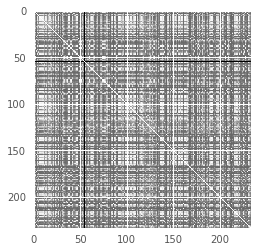

In [123]:
plt.imshow(M,cmap="Greys",interpolation="none")

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


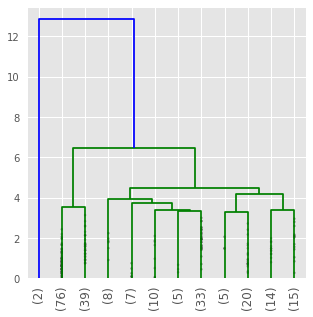

In [124]:
from scipy.cluster import hierarchy
Z = hierarchy.average(M)
plt.figure(figsize=(5,5))
hierarchy.dendrogram(
    Z,    
    truncate_mode='lastp',   # show only the last p merged clusters
    p=12,                    # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True
    )   
plt.show()

In [169]:
from scipy.cluster.hierarchy import fcluster
k=4
clusters = fcluster(Z, k, criterion='maxclust')
country_dict = {k: int(v) for k, v in zip(node_list, clusters)}

In [170]:
## delete a couple of marginalized countries 
del_cty = ['Niue','Martinique','Western Sahara','Haiti','Rwanda','Aruba']
try:
    [country_dict.pop(k) for k in del_cty]
except:
    pass
## delete nodes from the graph 
try:
    [G.remove_node(k) for k in del_cty]
except:
    pass

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


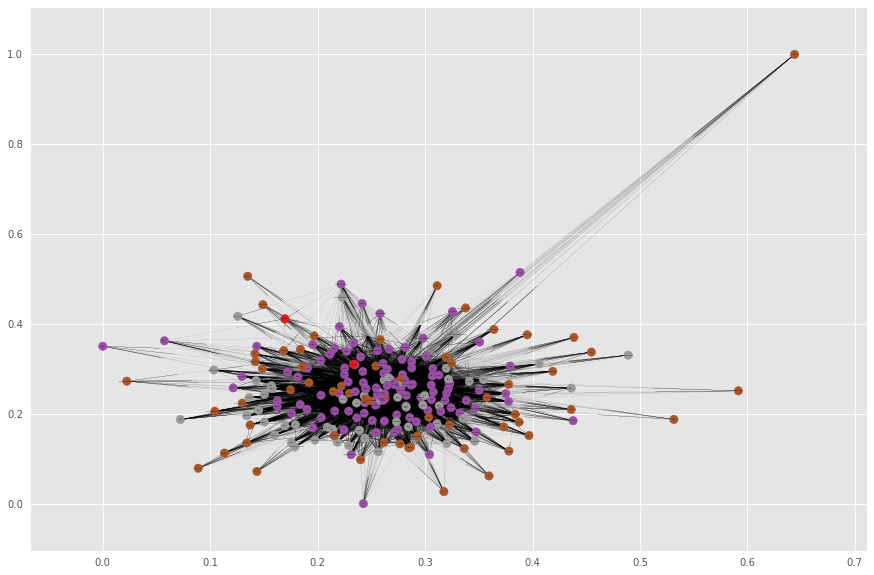

In [172]:
layout = nx.spring_layout(G)
plt.figure(1, figsize=(15,10))
nx.draw_networkx(G,
                 pos=layout,
                 nodelist=list(country_dict.keys()),
                 node_size = 70,  ## change the size of the node, based on degree
                 node_color=list(country_dict.values()),                   ## change color abased on degree
                 width=0.05,
                 font_size=1,
                 cmap='Set1',                                 ## choose one color map http://matplotlib.org/users/colormaps.html
                 )

In [19]:
nx.write_gexf(G, "2015.gexf")

## Visualizations

#### 2009
<img src="pic/2009.png" width=500 hight=500></img>
#### 2015
<img src="pic/2015.png" width=500 hight=500></img>